# CatBoost Feature Importance

In [71]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 
from catboost import *
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
# import shap
from time import time
import plotly.express as px
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from ydata_profiling import ProfileReport
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_columns', None)

Import Reformatted Dataset

In [75]:
RawData = pd.read_excel('Reformated.xlsx')

# EDA

In [6]:
# profile = ProfileReport(RawData, title="Profiling Report")
# profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:>

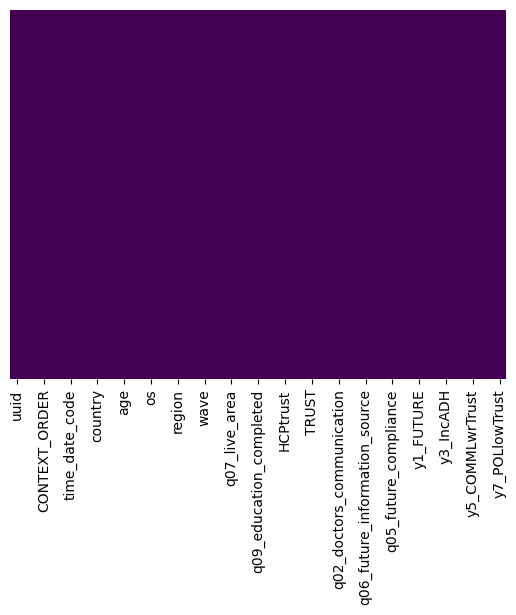

In [76]:
sns.heatmap(RawData.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [77]:
RawData.shape

(23282, 37)

In [78]:
RawData.columns

Index(['uuid', 'count', 'CONTEXT_ORDER', 'time_week_start_code',
       'time_date_code', 'age_group', 'country', 'city', 'age', 'ua', 'os',
       'device', 'region', 'gender', 'wave', 'q00a_select_language',
       'q07_live_area', 'q08_primary_covid_info_source',
       'q09_education_completed', 'COMMtrust', 'HCPtrust', 'POLtrust', 'TRUST',
       'q01_community_compliance', 'q02_doctors_communication',
       'q03_political_communication', 'q06_future_information_source',
       'q04_self_report_compliance', 'q05_future_compliance', 'y_xPastAdh',
       'y1_FUTURE', 'y2_DecADH', 'y3_IncADH', 'y4_InfoMISTRUST',
       'y5_COMMLwrTrust', 'y6_HCPLwrTrust', 'y7_POLlowTrust'],
      dtype='object')

In [220]:
df1 = dataset[['country', 'city', 'age', 'ua', 'os',
       'device', 'region', 'gender', 'wave', 'q00a_select_language',
       'q07_live_area', 'q08_primary_covid_info_source',
       'q09_education_completed', 'TRUST', 'y_xPastAdh',
       'y1_FUTURE', 'y2_DecADH', 'y3_IncADH', 'y4_InfoMISTRUST',
       'y5_COMMLwrTrust', 'y6_HCPLwrTrust', 'y7_POLlowTrust']]

In [221]:
df1['country'].value_counts()

CA    3021
IN    2152
FR    2051
MX    2015
PH    2014
TR    2014
KR    2009
EG    2004
BR    2002
TH    2001
NG    1999
Name: country, dtype: int64

In [222]:
df1['country'].unique()

array(['CA', 'TH', 'EG', 'IN', 'PH', 'NG', 'FR', 'KR', 'BR', 'MX', 'TR'],
      dtype=object)

# Country Charts

In [699]:
mask1 = df1['country'] == 'MX'
df2 = df1[mask1]
df2['q00a_select_language'].value_counts()

#Keep language select

DEFAULT    2015
Name: q00a_select_language, dtype: int64

In [700]:
# 'ua', 'os','device', 'region'


#DEAL WITH RARE INSTANCES 
counts = df2['ua'].value_counts()
infrequent_categories = counts[counts < 100].index   
df2['ua'] = df2['ua'].replace(infrequent_categories, 'other')

counts = df2['os'].value_counts()
infrequent_categories = counts[counts < 100].index   
df2['os'] = df2['os'].replace(infrequent_categories, 'other')

counts = df2['device'].value_counts()
infrequent_categories = counts[counts < 200].index   
df2['device'] = df2['device'].replace(infrequent_categories, 'other')

counts = df2['region'].value_counts()
infrequent_categories = counts[counts < 50].index   
df2['region'] = df2['region'].replace(infrequent_categories, 'other')

Categorical?

In [701]:
categorical_features_indices = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Past ADHERENCE

In [702]:
df3 = df2[['age', 'ua', 'os', 'device', 'region', 'gender',
       'wave', 'q00a_select_language', 'q07_live_area',
       'q08_primary_covid_info_source', 'q09_education_completed',
       'TRUST', 'y_xPastAdh']]

X_train, X_test, y_train, y_test = train_test_split(df3.drop('y_xPastAdh', axis = 1), df3['y_xPastAdh'], \
                                                    train_size=0.75, random_state=25)

#Train
model = CatBoostClassifier(one_hot_max_size = 10, iterations = 500)
model.fit(
    X_train, y_train,
    cat_features = categorical_features_indices,
    verbose = False
)

In [703]:
y_pred = model.predict(X_test)
PastAcc = accuracy_score(y_test, y_pred)
accuracy_score(y_test, y_pred)

0.746031746031746

In [704]:
fI1 = model.get_feature_importance(
Pool(X_train, y_train, cat_features=categorical_features_indices))

data = pd.DataFrame({'feature_importance': fI1, 
              'feature_names': X_train.columns}).sort_values(by=['feature_importance'], 
                                                       ascending=False)


### RENAME HERE
scaler = MinMaxScaler()
data['MEXICO'] = scaler.fit_transform(data[['feature_importance']])

In [705]:
#UPDATE

df4 = data[['feature_names', 'MEXICO']]

# PastAd_df = df4
PastAd_df = pd.merge(PastAd_df, df4, on='feature_names')

PastAd_df

,feature_names,CANADA,THAILAND,EGYPT,INDIA,PHIL,TURKEY,NIGERIA,FRANCE,S_KOREA,BRAZIL,MEXICO
0,TRUST,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,q09_education_completed,0.478428,0.793906,0.587772,0.354746,0.410420,0.964233,0.426913,0.561780,0.708573,0.604006,0.662798
2,q08_primary_covid_info_source,0.418286,0.966365,0.658906,0.339664,0.301879,0.776459,0.491562,0.508295,0.741110,0.970490,0.593345
3,age,0.374213,0.928990,0.915761,0.192815,0.198916,0.702419,0.486232,0.500830,0.537788,0.540015,0.650562
4,region,0.209127,0.581596,0.377395,0.310865,0.249562,0.446555,0.282635,0.208203,0.441018,0.501634,0.474070
5,q07_live_area,0.205886,0.497596,0.280761,0.168905,0.190068,0.378626,0.320893,0.464713,0.509503,0.447527,0.372690
6,gender,0.135759,0.318169,0.023618,0.096085,0.032898,0.354835,0.167502,0.236762,0.272025,0.362674,0.340602
7,ua,0.108887,0.255932,0.268095,0.097277,0.114255,0.323187,0.299570,0.278925,0.332414,0.276426,0.278317
8,os,0.087816,0.257202,0.036148,0.054012,0.032244,0.318202,0.116864,0.245971,0.235761,0.238465,0.139819
9,device,0.058839,0.167315,0.000000,0.000000,0.051016,0.247537,0.094370,0.230532,0.192206,0.136538,0.153915


# FUTURE ADHERENCE

In [706]:
#Features vs. likihood of FUTURE ADHERENCE
df3 = df2[['age', 'ua', 'os', 'device', 'region', 'gender',
       'wave', 'q00a_select_language', 'q07_live_area',
       'q08_primary_covid_info_source', 'q09_education_completed',
       'TRUST', 'y1_FUTURE']]

X_train, X_test, y_train, y_test = train_test_split(df3.drop('y1_FUTURE', axis = 1), df3['y1_FUTURE'], \
                                                    train_size=0.75, random_state=25)

#Train
model = CatBoostClassifier(one_hot_max_size = 10, iterations = 500)
model.fit(
    X_train, y_train,
    cat_features = categorical_features_indices,
    verbose = False
)

Test

In [707]:
y_pred = model.predict(X_test)
FAacc = accuracy_score(y_test, y_pred)
accuracy_score(y_test, y_pred)

0.746031746031746

RELATIVE IMPORTANCE OF FEATURES

In [708]:
fI1 = model.get_feature_importance(
Pool(X_train, y_train, cat_features=categorical_features_indices))

data = pd.DataFrame({'feature_importance': fI1, 
              'feature_names': X_train.columns}).sort_values(by=['feature_importance'], 
                                                       ascending=False)


### RENAME HERE
scaler = MinMaxScaler()
data['MEXICO'] = scaler.fit_transform(data[['feature_importance']])

In [709]:
#UPDATE

df4 = data[['feature_names', 'MEXICO']]

# FutAd_df = df4
FutAd_df = pd.merge(FutAd_df, df4, on='feature_names')

FutAd_df

,feature_names,CANADA,THAILAND,EGYPT,INDIA,PHIL,TURKEY,NIGERIA,FRANCE,S_KOREA,BRAZIL,MEXICO
0,TRUST,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,age,0.524529,0.666143,0.513317,0.298174,0.210746,0.807246,0.605567,0.521495,0.688715,0.459063,0.712492
2,q08_primary_covid_info_source,0.461415,0.924975,0.558510,0.415064,0.305021,0.747991,0.485502,0.347587,0.834475,0.830143,0.738798
3,q09_education_completed,0.438141,0.680719,0.668753,0.302778,0.271717,0.950859,0.584904,0.494805,0.657234,0.522604,0.725394
4,q07_live_area,0.315207,0.421805,0.374698,0.257125,0.145445,0.475456,0.400673,0.393303,0.320697,0.388943,0.426865
5,region,0.278892,0.520337,0.285544,0.408060,0.258421,0.421438,0.286085,0.200557,0.572561,0.544138,0.493031
6,ua,0.225714,0.242521,0.105026,0.086064,0.043465,0.388165,0.259230,0.192147,0.264357,0.207850,0.368220
7,gender,0.170716,0.302259,0.106859,0.075244,0.054531,0.381650,0.186408,0.164487,0.302529,0.292334,0.424847
8,os,0.145269,0.162139,0.080555,0.046059,0.012675,0.259988,0.123589,0.219792,0.274115,0.196382,0.161746
9,device,0.126976,0.176520,0.000000,0.000000,0.002892,0.174375,0.064749,0.194459,0.162187,0.182877,0.163710


# Predicted DECLINES in FUTURE ADHERENCE

In [710]:
df3 = df2[['age', 'ua', 'os', 'device', 'region', 'gender',
       'wave', 'q00a_select_language', 'q07_live_area',
       'q08_primary_covid_info_source', 'q09_education_completed',
       'TRUST', 'y2_DecADH']]

X_train, X_test, y_train, y_test = train_test_split(df3.drop('y2_DecADH', axis = 1), df3['y2_DecADH'], train_size=0.75, random_state=25)

#Train
model = CatBoostClassifier(one_hot_max_size = 10, iterations = 500)
model.fit(
    X_train, y_train,
    cat_features = categorical_features_indices,
    verbose = False
)

In [711]:
y_pred = model.predict(X_test)
DEC = accuracy_score(y_test, y_pred)
accuracy_score(y_test, y_pred)

0.8154761904761905

In [712]:
fI1 = model.get_feature_importance(
Pool(X_train, y_train, cat_features=categorical_features_indices))

data = pd.DataFrame({'feature_importance': fI1, 
              'feature_names': X_train.columns}).sort_values(by=['feature_importance'], 
                                                       ascending=False)


### RENAME HERE
scaler = MinMaxScaler()
data['MEXICO'] = scaler.fit_transform(data[['feature_importance']])

In [713]:
#UPDATE

df4 = data[['feature_names', 'MEXICO']]

# DecADH_df = df4
DecADH_df = pd.merge(DecADH_df, df4, on='feature_names')

DecADH_df

,feature_names,CANADA,THAILAND,EGYPT,INDIA,PHIL,TURKEY,NIGERIA,FRANCE,S_KOREA,BRAZIL,MEXICO
0,age,1.000000,1.000000,0.719635,0.794486,0.954555,0.778719,1.000000,1.000000,0.948041,0.608175,1.000000
1,q08_primary_covid_info_source,0.795836,0.954492,1.000000,0.982135,1.000000,1.000000,0.882638,0.887045,0.899534,0.904237,0.875779
2,q09_education_completed,0.698294,0.550469,0.633689,0.461288,0.572109,0.712482,0.693872,0.915049,0.621001,0.560001,0.829528
3,region,0.491503,0.897910,0.456741,1.000000,0.919095,0.586979,0.288542,0.461979,1.000000,1.000000,0.642440
4,q07_live_area,0.391639,0.635030,0.375634,0.705213,0.477312,0.514748,0.818188,0.650722,0.461284,0.487857,0.580652
5,TRUST,0.383854,0.468677,0.271788,0.389912,0.209176,0.491684,0.280209,0.344789,0.515500,0.373410,0.483897
6,ua,0.356331,0.455907,0.206581,0.275772,0.112698,0.402499,0.628564,0.615124,0.627254,0.413623,0.473505
7,os,0.353231,0.293467,0.009700,0.073332,0.005825,0.336004,0.318054,0.370349,0.367194,0.244422,0.236167
8,gender,0.235380,0.316114,0.216963,0.216467,0.057445,0.432862,0.258808,0.511181,0.320113,0.298627,0.434840
9,device,0.203106,0.203865,0.000000,0.000000,0.000000,0.198350,0.174874,0.440254,0.278617,0.162997,0.180462


# Predicted INCREASES in FUTURE ADHERENCE

In [714]:
df3 = df2[['age', 'ua', 'os', 'device', 'region', 'gender',
       'wave', 'q00a_select_language', 'q07_live_area',
       'q08_primary_covid_info_source', 'q09_education_completed',
       'TRUST', 'y3_IncADH']]

X_train, X_test, y_train, y_test = train_test_split(df3.drop('y3_IncADH', axis = 1), df3['y3_IncADH'], train_size=0.75, random_state=25)

#Train
model = CatBoostClassifier(one_hot_max_size = 10, iterations = 500)
model.fit(
    X_train, y_train,
    cat_features = categorical_features_indices,
    verbose = False
)

In [715]:
y_pred = model.predict(X_test)
INC = accuracy_score(y_test, y_pred)
accuracy_score(y_test, y_pred)

0.8015873015873016

In [716]:
fI1 = model.get_feature_importance(
Pool(X_train, y_train, cat_features=categorical_features_indices))

data = pd.DataFrame({'feature_importance': fI1, 
              'feature_names': X_train.columns}).sort_values(by=['feature_importance'], 
                                                       ascending=False)


### RENAME HERE
scaler = MinMaxScaler()
data['MEXICO'] = scaler.fit_transform(data[['feature_importance']])

In [717]:
#UPDATE

df4 = data[['feature_names', 'MEXICO']]

# IncADH_df = df4
IncADH_df = pd.merge(IncADH_df, df4, on='feature_names')

IncADH_df

,feature_names,CANADA,THAILAND,EGYPT,INDIA,PHIL,TURKEY,NIGERIA,FRANCE,S_KOREA,BRAZIL,MEXICO
0,age,1.000000,1.000000,1.000000,0.532342,0.703489,1.000000,0.904747,0.845411,0.775986,0.810819,1.000000
1,q08_primary_covid_info_source,0.863268,0.954492,0.957458,0.957218,0.856755,0.721569,1.000000,1.000000,0.700171,1.000000,0.873192
2,q09_education_completed,0.809313,0.550469,0.556064,0.534222,0.564491,0.869805,0.607940,0.768485,0.733931,0.616116,0.762749
3,q07_live_area,0.563857,0.635030,0.406842,0.477975,0.393809,0.837555,0.737537,0.667468,0.577236,0.453695,0.697003
4,region,0.492565,0.897910,0.663549,1.000000,1.000000,0.664555,0.550287,0.458953,1.000000,0.933184,0.730987
5,gender,0.373531,0.316114,0.149607,0.210420,0.155600,0.443279,0.321425,0.473638,0.459311,0.382357,0.420861
6,ua,0.354876,0.455907,0.323632,0.329506,0.281558,0.465438,0.619613,0.732236,0.500456,0.365271,0.585095
7,os,0.306303,0.293467,0.101726,0.160934,0.157437,0.329002,0.213424,0.463471,0.322124,0.407665,0.229945
8,TRUST,0.135892,0.468677,0.278527,0.402851,0.390553,0.375078,0.409155,0.265913,0.286455,0.305722,0.296739
9,wave,0.057040,0.252268,0.188943,0.134607,0.025175,0.245702,0.239423,0.329412,0.345391,0.282668,0.307869


# MISTRUST of FUTURE INFORMATION SOURCES

In [718]:


df3 = df2[['age', 'ua', 'os', 'device', 'region', 'gender',
       'wave', 'q00a_select_language', 'q07_live_area',
       'q08_primary_covid_info_source', 'q09_education_completed',
       'TRUST', 'y4_InfoMISTRUST']]

X_train, X_test, y_train, y_test = train_test_split(df3.drop('y4_InfoMISTRUST', axis = 1), df3['y4_InfoMISTRUST'], train_size=0.75, random_state=25)

#Train
model = CatBoostClassifier(one_hot_max_size = 10, iterations = 500)
model.fit(
    X_train, y_train,
    cat_features = categorical_features_indices,
    verbose = False
)

In [719]:
y_pred = model.predict(X_test)
MIS = accuracy_score(y_test, y_pred)
accuracy_score(y_test, y_pred)

0.8968253968253969

In [720]:
fI1 = model.get_feature_importance(
Pool(X_train, y_train, cat_features=categorical_features_indices))

data = pd.DataFrame({'feature_importance': fI1, 
              'feature_names': X_train.columns}).sort_values(by=['feature_importance'], 
                                                       ascending=False)


### RENAME HERE
scaler = MinMaxScaler()
data['MEXICO'] = scaler.fit_transform(data[['feature_importance']])

In [721]:
#UPDATE

df4 = data[['feature_names', 'MEXICO']]

# InfoMistrust_df = df4
InfoMistrust_df = pd.merge(InfoMistrust_df, df4, on='feature_names')

InfoMistrust_df

,feature_names,CANADA,THAILAND,EGYPT,INDIA,PHIL,TURKEY,NIGERIA,FRANCE,S_KOREA,BRAZIL,MEXICO
0,TRUST,1.000000,0.479656,0.437146,0.212601,0.113048,0.712885,0.188159,0.819936,0.524770,0.417225,0.413721
1,q08_primary_covid_info_source,0.998157,1.000000,0.978302,1.000000,1.000000,1.000000,1.000000,0.944227,0.956310,1.000000,0.896467
2,age,0.790781,0.807440,1.000000,0.822224,0.971538,0.809106,0.817726,1.000000,0.798205,0.628385,1.000000
3,q09_education_completed,0.749439,0.658351,0.916756,0.711745,0.811963,0.846070,0.810016,0.776263,0.871195,0.520323,0.760036
4,region,0.548603,0.742274,0.599041,0.897857,0.824393,0.611051,0.744367,0.308064,1.000000,0.627118,0.622476
5,q07_live_area,0.535635,0.699871,0.655845,0.478843,0.458650,0.619225,0.780325,0.664195,0.645633,0.344834,0.815289
6,ua,0.390720,0.362762,0.456704,0.204632,0.232448,0.404988,0.509331,0.430280,0.507220,0.289667,0.532845
7,os,0.306991,0.348133,0.166804,0.099846,0.104853,0.369307,0.106508,0.320292,0.360874,0.163151,0.223686
8,gender,0.263831,0.300153,0.229735,0.175964,0.323582,0.418351,0.111841,0.313934,0.335504,0.249621,0.489104
9,wave,0.187186,0.304319,0.229018,0.108445,0.000000,0.289486,0.107720,0.270742,0.305227,0.177340,0.269877


REMOVING TRUST from features, so not on both sides of equation

No need to update categorical featuers index


# Predicting Relatively LOW TRUST in COMMUNITY

In [722]:
# 'y5_COMMLwrTrust'

df3 = df2[['age', 'ua', 'os', 'device', 'region', 'gender',
       'wave', 'q00a_select_language', 'q07_live_area',
       'q08_primary_covid_info_source', 'q09_education_completed', 'y5_COMMLwrTrust']]

X_train, X_test, y_train, y_test = train_test_split(df3.drop('y5_COMMLwrTrust', axis = 1), df3['y5_COMMLwrTrust'], train_size=0.75, random_state=25)



#Train
model = CatBoostClassifier(one_hot_max_size = 10, iterations = 500)
model.fit(
    X_train, y_train,
    cat_features = categorical_features_indices,
    verbose = False
)

In [723]:
y_pred = model.predict(X_test)
COMM = accuracy_score(y_test, y_pred)
accuracy_score(y_test, y_pred)

0.9186507936507936

In [724]:
fI1 = model.get_feature_importance(
Pool(X_train, y_train, cat_features=categorical_features_indices))

data = pd.DataFrame({'feature_importance': fI1, 
              'feature_names': X_train.columns}).sort_values(by=['feature_importance'], 
                                                       ascending=False)


### RENAME HERE
scaler = MinMaxScaler()
data['MEXICO'] = scaler.fit_transform(data[['feature_importance']])

In [725]:
#UPDATE

df4 = data[['feature_names', 'MEXICO']]

# COMM_df = df4
COMM_df= pd.merge(COMM_df, df4, on='feature_names')

COMM_df

,feature_names,CANADA,THAILAND,EGYPT,INDIA,PHIL,TURKEY,NIGERIA,FRANCE,S_KOREA,BRAZIL,MEXICO
0,q08_primary_covid_info_source,1.000000,1.000000,0.842241,0.802990,0.982576,1.000000,1.000000,1.000000,0.926296,1.000000,0.600569
1,age,0.673908,0.974471,1.000000,0.737635,0.691594,0.882166,0.847597,0.915178,1.000000,0.722522,1.000000
2,q09_education_completed,0.571754,0.694996,0.648236,0.492978,0.656259,0.967919,0.675013,0.806922,0.832043,0.547504,0.670396
3,q07_live_area,0.449243,0.508851,0.401664,0.482407,0.461764,0.701901,0.897948,0.635410,0.696975,0.418603,0.619258
4,ua,0.436986,0.418345,0.407537,0.303250,0.173898,0.452736,0.445612,0.633379,0.604725,0.303394,0.493608
5,region,0.403547,0.781419,0.519508,1.000000,1.000000,0.720704,0.422831,0.369511,0.809093,0.954680,0.680283
6,gender,0.302083,0.453096,0.216174,0.185716,0.062704,0.483244,0.153338,0.488715,0.346696,0.250663,0.354488
7,os,0.214945,0.453563,0.070624,0.118365,0.069836,0.377436,0.164763,0.268269,0.378350,0.218856,0.327974
8,wave,0.117764,0.513896,0.193652,0.203964,0.095788,0.503943,0.295314,0.466829,0.350988,0.247371,0.417283
9,device,0.031334,0.205720,0.067742,0.000000,0.000000,0.261831,0.156220,0.278625,0.188739,0.128545,0.113082


# Predicting Relatively LOW TRUST in HEALTHCARE PROVIDERS

In [726]:
# 'y6_HCPLwrTrust'

df3 = df2[['age', 'ua', 'os', 'device', 'region', 'gender',
       'wave', 'q00a_select_language', 'q07_live_area',
       'q08_primary_covid_info_source', 'q09_education_completed', 'y6_HCPLwrTrust']]

X_train, X_test, y_train, y_test = train_test_split(df3.drop('y6_HCPLwrTrust', axis = 1), df3['y6_HCPLwrTrust'], train_size=0.75, random_state=25)

#Train
model = CatBoostClassifier(one_hot_max_size = 10, iterations = 500)
model.fit(
    X_train, y_train,
    cat_features = categorical_features_indices,
    verbose = False
)

In [727]:
y_pred = model.predict(X_test)
HCP = accuracy_score(y_test, y_pred)
accuracy_score(y_test, y_pred)

0.9900793650793651

In [728]:
fI1 = model.get_feature_importance(
Pool(X_train, y_train, cat_features=categorical_features_indices))

data = pd.DataFrame({'feature_importance': fI1, 
              'feature_names': X_train.columns}).sort_values(by=['feature_importance'], 
                                                       ascending=False)


### RENAME HERE
scaler = MinMaxScaler()
data['MEXICO'] = scaler.fit_transform(data[['feature_importance']])

In [729]:
#UPDATE

df4 = data[['feature_names', 'MEXICO']]

# HCP_df = df4
HCP_df = pd.merge(HCP_df, df4, on='feature_names')

HCP_df

,feature_names,CANADA,THAILAND,EGYPT,INDIA,PHIL,TURKEY,NIGERIA,FRANCE,S_KOREA,BRAZIL,MEXICO
0,q09_education_completed,1.000000,0.919461,0.733068,0.778529,1.000000,1.000000,0.753563,0.667285,0.905041,0.751237,0.905118
1,age,0.807213,0.571114,0.746409,1.000000,0.663052,0.627135,1.000000,1.000000,1.000000,0.999659,1.000000
2,q08_primary_covid_info_source,0.475143,0.842182,1.000000,0.928324,0.592824,0.519051,0.449449,0.611621,0.571693,0.902743,0.642905
3,region,0.418825,1.000000,0.533277,0.846381,0.534259,0.401140,0.369069,0.296369,0.924696,1.000000,0.738548
4,ua,0.296913,0.351610,0.388446,0.194695,0.209151,0.364644,0.439225,0.681824,0.655028,0.862912,0.484451
5,q07_live_area,0.295750,0.782030,0.690330,0.879946,0.819208,0.378437,0.833467,0.801478,0.667623,0.893875,0.652890
6,wave,0.249731,0.291056,0.313030,0.250986,0.242341,0.342747,0.393285,0.598896,0.404107,0.453412,0.736596
7,os,0.247694,0.203838,0.153536,0.077599,0.077630,0.195309,0.061822,0.505946,0.524117,0.462605,0.186824
8,gender,0.176456,0.532679,0.151884,0.264203,0.272268,0.537550,0.198617,0.451316,0.369239,0.389968,0.398074
9,q00a_select_language,0.002987,0.000000,0.000000,0.185850,0.308205,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Predicting Relatively LOW TRUST in POLITICAL Comms

In [730]:
'y7_POLlowTrust'

df3 = df2[['age', 'ua', 'os', 'device', 'region', 'gender',
       'wave', 'q00a_select_language', 'q07_live_area',
       'q08_primary_covid_info_source', 'q09_education_completed', 'y7_POLlowTrust']]

X_train, X_test, y_train, y_test = train_test_split(df3.drop('y7_POLlowTrust', axis = 1), df3['y7_POLlowTrust'], train_size=0.75, random_state=25)

#Train
model = CatBoostClassifier(one_hot_max_size = 10, iterations = 500)
model.fit(
    X_train, y_train,
    cat_features = categorical_features_indices,
    verbose = False
)

In [731]:
y_pred = model.predict(X_test)
POL = accuracy_score(y_test, y_pred)
accuracy_score(y_test, y_pred)

0.9722222222222222

In [732]:
fI1 = model.get_feature_importance(
Pool(X_train, y_train, cat_features=categorical_features_indices))

data = pd.DataFrame({'feature_importance': fI1, 
              'feature_names': X_train.columns}).sort_values(by=['feature_importance'], 
                                                       ascending=False)


### RENAME HERE
scaler = MinMaxScaler()
data['MEXICO'] = scaler.fit_transform(data[['feature_importance']])

In [733]:
#UPDATE

df4 = data[['feature_names', 'MEXICO']]

# POL_df = df4
POL_df = pd.merge(POL_df, df4, on='feature_names')

POL_df

,feature_names,CANADA,THAILAND,EGYPT,INDIA,PHIL,TURKEY,NIGERIA,FRANCE,S_KOREA,BRAZIL,MEXICO
0,q08_primary_covid_info_source,1.000000,1.000000,0.785538,1.000000,0.511175,0.809312,0.537753,0.622780,1.000000,0.951909,0.612001
1,q09_education_completed,0.981386,0.725060,1.000000,0.725503,0.606997,0.811531,0.443971,1.000000,0.748777,0.628746,0.785751
2,age,0.944772,0.941242,0.913122,0.821654,1.000000,1.000000,1.000000,0.880633,0.927769,0.843664,1.000000
3,q07_live_area,0.747832,0.564063,0.792017,0.660168,0.828195,0.715733,0.726903,0.684867,0.665139,0.554445,0.686711
4,region,0.544527,0.600157,0.437121,0.945457,0.813227,0.682945,0.451957,0.344816,0.783226,1.000000,0.496826
5,ua,0.460090,0.229400,0.494869,0.381799,0.576946,0.415061,0.515282,0.525860,0.712013,0.377258,0.649310
6,os,0.431290,0.260012,0.023577,0.080842,0.214320,0.340833,0.053247,0.391776,0.396509,0.257170,0.145930
7,wave,0.366402,0.322459,0.429794,0.203551,0.294334,0.468221,0.295664,0.382619,0.460485,0.279744,0.432165
8,gender,0.345062,0.450529,0.212303,0.161270,0.555756,0.354715,0.176308,0.383553,0.545020,0.247694,0.370779
9,device,0.110806,0.204824,0.000000,0.000000,0.032570,0.284637,0.094292,0.286581,0.241765,0.150006,0.096840


# Predicting TRUST

Predicting trust using information source, education, age, urban/rural, gender, language and region

In [734]:
categorical_features_indicesB = [1, 2, 3, 4, 5, 6, 7]

In [735]:
df3 = df2[['age', 'region', 'gender',
       'wave', 'q00a_select_language', 'q07_live_area',
       'q08_primary_covid_info_source', 'q09_education_completed',
       'TRUST']]

X_train, X_test, y_train, y_test = train_test_split(df3.drop('TRUST', axis = 1), df3['TRUST'], train_size=0.75, random_state=25)

#Train
model = CatBoostClassifier(one_hot_max_size = 10, iterations = 500)
model.fit(
    X_train, y_train,
    cat_features = categorical_features_indicesB,
    verbose = False
)

In [736]:
y_pred = model.predict(X_test)
TRUST = accuracy_score(y_test, y_pred)
accuracy_score(y_test, y_pred)

0.5317460317460317

In [737]:
fI1 = model.get_feature_importance(
Pool(X_train, y_train, cat_features=categorical_features_indicesB))

data = pd.DataFrame({'feature_importance': fI1, 
              'feature_names': X_train.columns}).sort_values(by=['feature_importance'], 
                                                       ascending=False)


### RENAME HERE
scaler = MinMaxScaler()
data['MEXICO'] = scaler.fit_transform(data[['feature_importance']])

In [738]:
#UPDATE

df4 = data[['feature_names', 'MEXICO']]

# Trust_df = df4
Trust_df = pd.merge(Trust_df, df4, on='feature_names')

Trust_df

,feature_names,CANADA,THAILAND,EGYPT,INDIA,PHIL,TURKEY,NIGERIA,FRANCE,S_KOREA,BRAZIL,MEXICO
0,q08_primary_covid_info_source,1.000000,0.958087,0.867312,1.000000,1.000000,1.000000,0.767423,1.000000,1.000000,1.000000,0.933598
1,age,0.871226,1.000000,1.000000,0.523254,0.720850,0.749605,1.000000,0.918901,0.808783,0.801984,1.000000
2,region,0.527089,0.909397,0.556198,0.776110,0.668404,0.610946,0.597108,0.537062,0.944620,0.953436,0.841705
3,q09_education_completed,0.520122,0.586918,0.561112,0.383812,0.789225,0.610644,0.563582,0.677900,0.555446,0.679203,0.834995
4,q07_live_area,0.407842,0.486191,0.368091,0.253460,0.444111,0.523155,0.537551,0.638818,0.534540,0.612102,0.605225
5,gender,0.205393,0.374387,0.055997,0.071419,0.165715,0.383858,0.277533,0.452616,0.553935,0.359278,0.483363
6,wave,0.038874,0.240177,0.123544,0.000000,0.000000,0.315759,0.152096,0.335222,0.251667,0.231385,0.514858
7,q00a_select_language,0.000000,0.000000,0.000000,0.036567,0.033607,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# MODEL ACCURACY

In [739]:
ModelAccuracy = {'Score': [PastAcc, FAacc, DEC, INC, MIS, COMM, HCP, POL, TRUST],
                                   'Predicting': ['Past_Adherence','Future_Adherence', 'Decling_Adherence', 'Increasing_Adherence', 'Mistrust_Info', 'COMM_Mistrust', 'HCP_Mistrust', 'POL_Mistrust', 'Trust']}

ModelAccuracy_df = pd.DataFrame(ModelAccuracy)

ModelAccuracy_df = ModelAccuracy_df.set_index('Predicting')

MEX_SCORES = ModelAccuracy_df

print(ModelAccuracy_df)

                         Score
Predicting                    
Past_Adherence        0.746032
Future_Adherence      0.746032
Decling_Adherence     0.815476
Increasing_Adherence  0.801587
Mistrust_Info         0.896825
COMM_Mistrust         0.918651
HCP_Mistrust          0.990079
POL_Mistrust          0.972222
Trust                 0.531746


In [742]:
# writer = pd.ExcelWriter('AccScores.xlsx', engine='xlsxwriter')

# CANADA_SCORES.to_excel(writer, sheet_name = 'CA')
# THAI_SCORES.to_excel(writer, sheet_name = 'TH')
# EGYPT_SCORES.to_excel(writer, sheet_name = 'EG')
# INDIA_SCORES.to_excel(writer, sheet_name = 'IN')
# PHILIPPINES_SCORES.to_excel(writer, sheet_name = 'PH')
# TURKEY_SCORES.to_excel(writer, sheet_name = 'TR')
# NIGERIA_SCORES.to_excel(writer, sheet_name = 'NG')
# FRANCE_SCORES.to_excel(writer, sheet_name = 'FR')
# KOREA_SCORES.to_excel(writer, sheet_name = 'SK')
# BRAZIL_SCORES.to_excel(writer, sheet_name = 'BZ')
# MEX_SCORES.to_excel(writer, sheet_name = 'MX')

# writer.save()

In [741]:
# writer = pd.ExcelWriter('OutputFeatureImport.xlsx', engine='xlsxwriter')

# PastAd_df.to_excel(writer, sheet_name = 'ADHR')
# FutAd_df.to_excel(writer, sheet_name = 'FutADHR')
# DecADH_df.to_excel(writer, sheet_name = 'DecADHR')
# IncADH_df.to_excel(writer, sheet_name = 'IncADHR')
# InfoMistrust_df.to_excel(writer, sheet_name = 'InfoMist')
# COMM_df.to_excel(writer, sheet_name = 'COMM')
# HCP_df.to_excel(writer, sheet_name = 'HCP')
# POL_df.to_excel(writer, sheet_name = 'POL')
# Trust_df.to_excel(writer, sheet_name = 'TRUST')

# writer.save()